In [28]:
import sys 
sys.path.append('../..')
from cox.utils import Parameters
from cox.store import Store
from cox.readers import CollectionReader
from sklearn.linear_model import LinearRegression
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import itertools
import os
import IPython
import numpy as np
import torch as ch
from torch import Tensor
from torch.distributions import Uniform, Laplace
from delphi.stats.linear_regression import TruncatedLinearRegression
from delphi.oracle import Left, Interval
import delphi.utils.constants as consts

os.environ['HDF5_USE_FILE_LOCKING'] = 'FALSE'

STORE_PATH = '/home/gridsan/stefanou/Regression/ManualSeed1'
STORE_TABLE_NAME = 'results'

# regression parameters
left = Left(Tensor([0.0]))

# procedure hyperparameters
args = Parameters({ 
    'epochs': 5,
    'workers': 0, 
    'batch_size': 100,
    'bias': True,
    'num_samples': 100,
    'samples': 1000, 
    'dims': 1, 
    'clamp': True, 
    'radius': 5.0, 
    'var_lr': 1e-2,
    'lr': 1e-2,
    'shuffle': False, 
    'eps': 1e-5, 
    'custom_lr_multiplier': consts.COSINE,
    'trials': 10,
    'tol': 1e-2,
    'w_lower': -1, 
    'w_upper': 1,
    'x_lower': -5, 
    'x_upper': 5,
        
})

if ch.cuda.is_available(): 
    args.__setattr__('device', 'cuda')
    print("using cuda...")
else: 
    args.__setattr__('device', 'cpu')
    print("using cpu...")
args.__setattr__('phi', left)

noise = 'laplace' #@param ['laplace', 'uniform', 'cauchy']

using cuda...


# Synthesize Data
For this experiment, instead of adding Gaussian noise to our ground-truth linear regression, we will add laplace noise. We will see if our methods can reduce bias in truncated regression setting when faced with an arbitrary noise distribution.

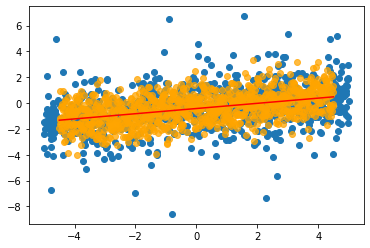

In [44]:
# MSE Loss
mse_loss = ch.nn.MSELoss()

# distribution for generating ground truth
U = Uniform(args.w_lower, args.w_upper)
U_ = Uniform(args.x_lower, args.x_upper)

dn_scale = ch.ones(1)
# assign noise distribution here
if noise == 'laplace': 
    dn = Laplace(ch.zeros(1), ch.ones(1))
elif noise == 'uniform': 
    dn = Uniform(0, 1)
elif noise == 'cauchy': 
    dn = Cauchy(ch.zeros(0), ch.ones(1))
else: 
    print("please pick a valid noise distribution")
    
    
# generate ground truth
ground_truth = ch.nn.Linear(in_features=args.dims, out_features=1, bias=args.bias)
ground_truth.weight = ch.nn.Parameter(U.sample(ch.Size([1, args.dims]))) 
# bias term 
if args.bias: 
    ground_truth.bias = ch.nn.Parameter(U.sample(ch.Size([1, 1])))

with ch.no_grad():
    # generate data
    X = U_.sample(ch.Size([args.samples, args.dims]))
    # add laplace noise to distribution instead
    rand_noise = dn.sample(ch.Size([X.size(0)]))
    y = ground_truth(X) + rand_noise


gt_ols = LinearRegression()
gt_ols.fit(X, y)

mesh = np.expand_dims(np.linspace(-4.5, 4.5, 1000), 1).reshape(1000, 1)

ax = plt.subplot(1, 1, 1)
plt.scatter(X, y, label='(x, y)')
plt.plot(mesh, gt_ols.predict(mesh), label='gt ols', color='red')
# plt.scatter(mesh, gt_ols.predict(mesh) + dn.sample(ch.Size([mesh.shape[0]])).numpy(), alpha=.75, label='laplace noise')
plt.scatter(mesh, gt_ols.predict(mesh) + np.random.randn(mesh.shape[0], 1), alpha=.75, label='gaussian noise', color='orange')

In [3]:
# distribution for generating ground truth
U = Uniform(args.lower, args.upper)

# increase variance up to 20
for var in range(1, 2):
    # create store and add table
    store = Store(STORE_PATH)

    store.add_table(STORE_TABLE_NAME, { 
        'known_param_mse': float,
        'unknown_param_mse': float,
        'unknown_var_mse': float,
        'ols_param_mse': float,
        'ols_var_mse': float,
        'alpha': float, 
        'var': float, 
    })
    
    ch.manual_seed(1)
    # generate ground truth
    ground_truth = ch.nn.Linear(in_features=args.in_features, out_features=1, bias=args.bias)
    ground_truth.weight = ch.nn.Parameter(U.sample(ch.Size([1, args.in_features]))) 
    ground_truth.bias = ch.nn.Parameter(U.sample(ch.Size([1, 1])))

    # generate data
    X = Uniform(-5, 5).sample(ch.Size([args.samples, args.in_features]))
    y = ground_truth(X) + ch.sqrt(Tensor([var])) * ch.randn(X.size())
    # truncate
    indices = args.phi(y).nonzero(as_tuple=False).flatten()
    y_trunc, x_trunc = y[indices].detach(), X[indices].detach()
    alpha = Tensor([y_trunc.size(0)/args.samples])

    # empirical linear regression
    ols = LinearRegression() 
    ols.fit(x_trunc, y_trunc)
    ols_var = ch.var(Tensor(ols.predict(x_trunc)) - y_trunc, dim=0)[..., None]

    # truncated linear regression with known noise variance
    trunc_reg = TruncatedLinearRegression(phi=args.phi, alpha=alpha, args=args, bias=args.bias, var=ols_var)
    results = trunc_reg.fit(x_trunc, y_trunc)
    w_, w0_ = results.weight.detach().cpu(), results.bias.detach().cpu()

    # truncated linear regression with unknown noise variance
    trunc_reg = TruncatedLinearRegression(phi=args.phi, alpha=alpha, args=args, bias=args.bias)
    results = trunc_reg.fit(x_trunc, y_trunc)
    var_ = results.lambda_.inverse().detach()
    w, w0 = (results.v.detach()*var_).cpu(), (results.bias.detach()*var_).cpu()

    # parameter estimates 
    real_params = ch.cat([ground_truth.weight.T, ground_truth.bias])
    ols_params = ch.cat([Tensor(ols.coef_).T, Tensor(ols.intercept_).unsqueeze(0)])
    unknown_params = ch.cat([w, w0])
    known_params = ch.cat([w_.T, w0_.unsqueeze(0)])

    # metrics
    unknown_param_mse = ch.nn.MSELoss()(unknown_params, real_params)
    unknown_var_mse = ch.nn.MSELoss()(var_, Tensor([var]))
    ols_param_mse = ch.nn.MSELoss()(Tensor(ols_params), Tensor(real_params))
    ols_var_mse = ch.nn.MSELoss()(ols_var, Tensor([var]))
    known_param_mse = ch.nn.MSELoss()(known_params, real_params)

    store[STORE_TABLE_NAME].append_row({ 
        'known_param_mse': known_param_mse,
        'unknown_param_mse': unknown_param_mse,
        'unknown_var_mse': unknown_var_mse,
        'ols_param_mse': ols_param_mse,
        'ols_var_mse': ols_var_mse,
        'alpha': float(alpha.flatten()),
        'var': float(var), 
    })

    IPython.display.clear_output(wait=False)

    # close current store
    store.close()

# Results

100%|██████████| 2/2 [00:00<00:00,  5.09it/s]


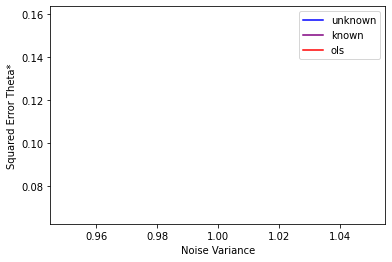

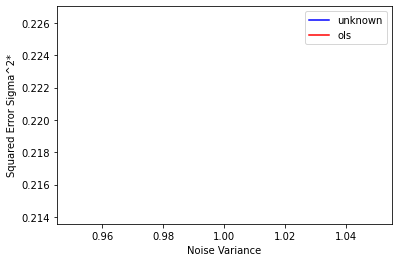

In [4]:
reader = CollectionReader(STORE_PATH)
results = reader.df(STORE_TABLE_NAME)
results.head()
reader.close() # close reader

# variance vs param mse
sns.lineplot(data=results, x='var', y='unknown_param_mse', label='unknown', color='blue')
sns.lineplot(data=results, x='var', y='known_param_mse', label='known', color='purple')
ax = sns.lineplot(data=results, x='var', y='ols_param_mse', label='ols', color='red')
ax.set(xlabel='Noise Variance', ylabel='Squared Error Theta*')
plt.show()

# var vs var mse
ax = sns.lineplot(data=results, x='var', y='unknown_var_mse', label='unknown', color='blue')
ax = sns.lineplot(data=results, x='var', y='ols_var_mse', label='ols', color='red')
ax.set(xlabel='Noise Variance', ylabel='Squared Error Sigma^2*')
plt.show()

In [5]:
results

,known_param_mse,unknown_param_mse,unknown_var_mse,ols_param_mse,ols_var_mse,alpha,var,exp_id
0,0.067113,0.087619,0.214188,0.158803,0.226417,0.6598,1.0,a6791cf1-57f0-4ddd-826c-1bb9a0015d4d


In [6]:
import matplotlib.pyplot as plt

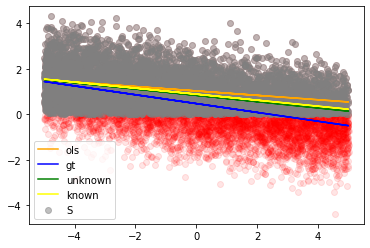

In [7]:
with ch.no_grad():
    plt.scatter(X, y, color='red', alpha=.1)
    plt.scatter(x_trunc, y_trunc, color='grey', label='S', alpha=.5)
    plt.plot(x_trunc, ols.predict(x_trunc), color="orange", label='ols')
    plt.plot(x_trunc, ground_truth(x_trunc), color='blue', label='gt')
    plt.plot(x_trunc, (x_trunc.mm(w_) + w0_), color='green', label='unknown')
    plt.plot(x_trunc, (x_trunc.mm(w) + w0), color='yellow', label='known')
    plt.legend()
    plt.show()

In [45]:
real_params

tensor([[-0.1939],
        [ 0.4694]], grad_fn=<CatBackward>)

In [25]:
from delphi import grad

trunc_mse = grad.TruncatedMSE.apply
trunc_unknown_mse = grad.TruncatedUnknownVarianceMSE.apply

In [34]:
pred = (x_trunc.mm(w_) + w0_)
pred.requires_grad = True
trunc_loss = trunc_mse(pred, y_trunc)

trunc_g, = ch.autograd.grad(trunc_loss, [pred])
trunc_g

tensor([[ 0.0002],
        [-0.0002],
        [ 0.0002],
        ...,
        [-0.0004],
        [-0.0004],
        [ 0.0002]])

In [35]:
alpha

tensor([0.2543])

In [30]:
import config

In [32]:
config.args.var = ols_var

In [38]:
ch.manual_seed(1)
# generate ground truth
ground_truth = ch.nn.Linear(in_features=args.in_features, out_features=1, bias=args.bias)
ground_truth.weight = ch.nn.Parameter(U.sample(ch.Size([1, args.in_features]))) 
ground_truth.bias = ch.nn.Parameter(U.sample(ch.Size([1, 1])))

# generate data
X = Uniform(-1, 1).sample(ch.Size([args.samples, args.in_features]))
y = ground_truth(X) + ch.sqrt(Tensor([var])) * ch.randn(y.size())
# truncate
indices = args.phi(y).nonzero(as_tuple=False).flatten()
y_trunc, x_trunc = y[indices].detach(), X[indices].detach()
alpha = Tensor([y_trunc.size(0)/args.samples])

In [39]:
alpha

tensor([0.6782])

In [1]:
import rpy2
print(rpy2.__version__)

ModuleNotFoundError: No module named 'rpy2'

In [ ]:
import subprocess 

command = 'Rscript'
path2scirpt = ''